# Libraries

In [1]:
import math
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

# Adding Assets and pulling historical data


In [2]:
stocks=['AAPL','TSLA','MCD','KO','TMO','MMM','NKE']

eD=dt.datetime.today()
sD=eD-dt.timedelta(2*365)

price=yf.download(stocks,
                  period = '2y')['Adj Close'].pct_change()
returns=price
al=len(stocks)

[*********************100%***********************]  7 of 7 completed


# Calculate the mean, variance, and correlation matrix for all assets

In [3]:
class Tools:
    def __init__(self,returns, assets):
        self.returns = returns
        self.assets = assets
 
    def simpleComp(self):
        self.tbl=pd.DataFrame(index=self.assets)
        self.tbl['Mean']=returns.mean()
        self.tbl['Variance']=returns.var()
        return(self.tbl.T)
   
    def correlation(self):
        self.tbl=pd.DataFrame(index=self.assets)
        self.corr=returns.corr()
        return(self.corr)

In [4]:
tls=Tools(returns=returns, assets=stocks)

display(tls.simpleComp().T,tls.correlation())

,Mean,Variance
AAPL,0.000692,0.000372
TSLA,0.000871,0.001433
MCD,0.000629,0.000125
KO,0.000462,0.000123
TMO,0.000497,0.000316
MMM,-0.000352,0.000211
NKE,-0.000176,0.000473


,AAPL,KO,MCD,MMM,NKE,TMO,TSLA
AAPL,1.000000,0.403579,0.427726,0.357068,0.537372,0.495306,0.547750
KO,0.403579,1.000000,0.598267,0.456131,0.322273,0.298804,0.132634
MCD,0.427726,0.598267,1.000000,0.394747,0.356962,0.314691,0.215750
MMM,0.357068,0.456131,0.394747,1.000000,0.365996,0.229999,0.158550
NKE,0.537372,0.322273,0.356962,0.365996,1.000000,0.438955,0.369262
TMO,0.495306,0.298804,0.314691,0.229999,0.438955,1.000000,0.374349
TSLA,0.547750,0.132634,0.215750,0.158550,0.369262,0.374349,1.000000


# Monte Carlo Simulation to Calculate Efficient Frontier


In [22]:
#portfolio returns
def pR(w):
    return np.sum(returns.mean() * w) * 252
#portfolio volumes
def pV(w):
    return np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252,w)))

retCol = []
volCol = []
wei =[]

for p in range (400000):
    
    weights = np.random.random(al)
    weights /= np.sum(weights)
    
    wei.append(weights)
    
    retCol.append(pR(weights))
    volCol.append(pV(weights))

ER = np.array(retCol)
EV = np.array(volCol)

sharpe=(ER-0.02)/EV

# Graph

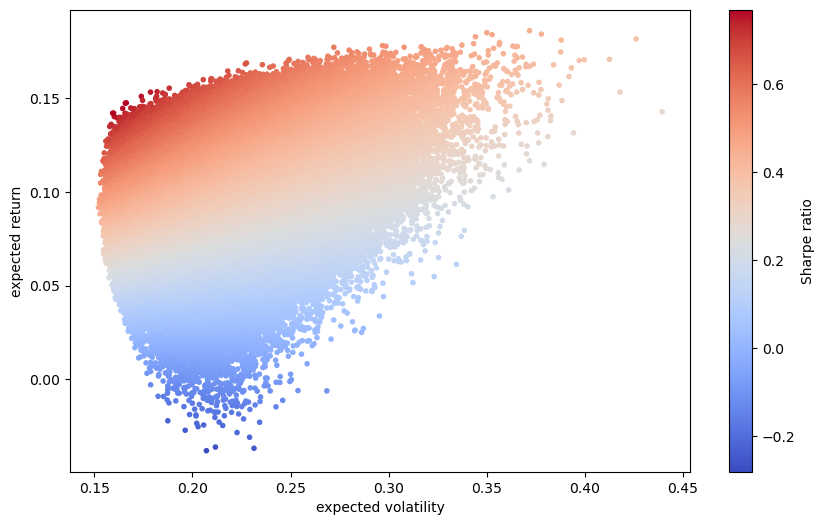

In [23]:
plt.figure(figsize=(10,6 ))
plt.scatter(EV, ER, c=sharpe,
marker='.', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

# Display Optimals

In [24]:
tbl2=pd.DataFrame(columns=['Expected Return',
                           'Volatility',
                           'Optimal Sharpe Ratio'])
tbl2['Expected Return']=ER
tbl2['Volatility']=EV
tbl2['Optimal Sharpe Ratio']=sharpe

for counter, symbol in enumerate(returns.columns.tolist()):
    tbl2[symbol + "'s weight"] = [w[counter] for w in wei]


tbl2.set_index("Optimal Sharpe Ratio", inplace=True)
portfolios = pd.DataFrame(tbl2)
tbl2F=portfolios.head().T
tbl2F


Optimal Sharpe Ratio,0.578235,0.276370,0.477150,0.314774,0.330300
Expected Return,0.161583,0.075471,0.104129,0.083086,0.074194
Volatility,0.244854,0.200712,0.176315,0.200418,0.164076
AAPL's weight,0.101335,0.245990,0.243600,0.166125,0.024303
KO's weight,0.140765,0.140156,0.131241,0.040510,0.221818
MCD's weight,0.356904,0.073973,0.279426,0.191797,0.239486
MMM's weight,0.002781,0.151715,0.142539,0.185397,0.263319
NKE's weight,0.035182,0.193846,0.067283,0.147013,0.047650
TMO's weight,0.073643,0.170539,0.128739,0.181659,0.138131
TSLA's weight,0.289390,0.023781,0.007172,0.087499,0.065292


# Using Liner Regression to Calculate Efficient Frontier 

In [25]:
def sharpeMinzd(w):
    return -(pR(w)-.02) / pV(w)

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for x in range(al))
eWV = np.array(al * [1. / al,])

sharpeMinzd(eWV)                   

-0.35675502796743236

In [26]:
sharpeOptimized=sco.minimize(sharpeMinzd,
                             eWV,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=constraints)

In [27]:
volOptimized=sco.minimize(pV,
                             eWV,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=constraints)

In [28]:
cons = ({'type': 'eq', 'fun': lambda x: pR(x) - treturn},
               {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

treturns = np.linspace(0.05, 0.2, 50)
tvolatility = []

for treturn in treturns:
    res = sco.minimize(pV, eWV, method='SLSQP',
                       bounds=bnds, 
                       constraints=cons)
    tvolatility.append(res['fun'])
tvolatility = np.array(tvolatility)

### Optimal Portfolio Returns

In [29]:

OPR=pR(sharpeOptimized['x'])
OPR.round(4)

0.156

### Optimal Portfolio Volatility Weighting

In [30]:
OPVW=pV(sharpeOptimized['x'])
OPVW.round(4)

0.1679

### Sharpe Ratio Maximized

In [31]:
SRM=(OPR-0.02)/OPVW
SRM.round(4)

0.8103

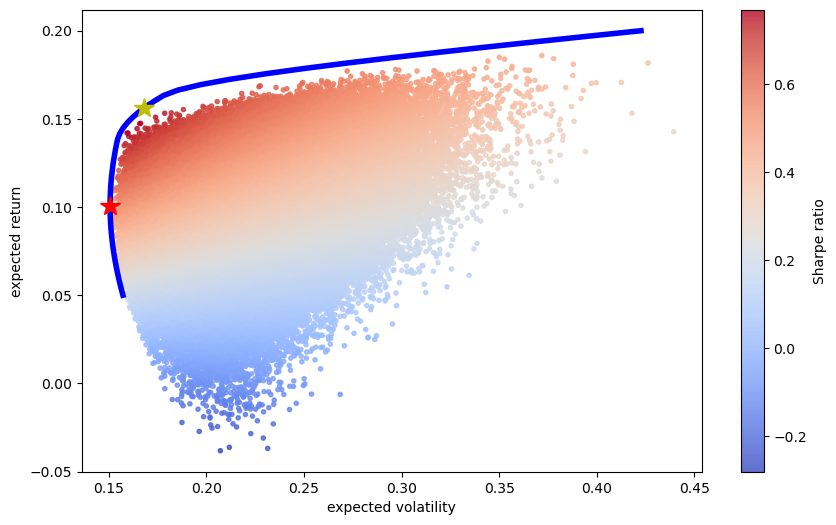

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(EV, ER, c=sharpe,marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvolatility, treturns, 'b', lw=4.0)
plt.plot(pV(sharpeOptimized['x']), pR(sharpeOptimized['x']),
         'y*', markersize=15.0)
plt.plot(pV(volOptimized['x']), pR(volOptimized['x']),
         'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')